# Preprocess dorsal midbrain

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

## Load the dataset

In [3]:
# Load the dataset.
adata = sc.read_h5ad(
    "/pasteur/zeus/projets/p02/ml4ig_hot/Users/ghuizing/data/dorsal_midbrain/Dorsal_midbrain_cell_bin.h5ad"
)
print("Loaded dataset: ", adata)

Loaded dataset:  AnnData object with n_obs × n_vars = 26738 × 24045
    obs: 'CellID', 'Batch', 'annotation', 'S_score', 'G2M_score', 'phase', 'Time point'
    var: 'Gene'
    uns: 'FP200000600TR_E3', 'SS200000108BR_A3A4', 'SS200000108BR_B1B2', 'SS200000131BL_C3C4', 'SS200000131BL_C5C6', 'angle_dict', 'annotation_colors'
    obsm: 'X_umap', 'spatial'
    layers: 'counts'


In [4]:
# Subset the data
idx = adata.obs["Batch"] == "FP200000600TR_E3"
idx |= adata.obs["Batch"] == "SS200000108BR_A3A4"
idx |= adata.obs["Batch"] == "SS200000108BR_B1B2"
adata = adata[idx]

/pasteur/appa/homes/ghuizing/.cache/pypoetry/virtualenvs/spacetime-5ClciJgR-py3.10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


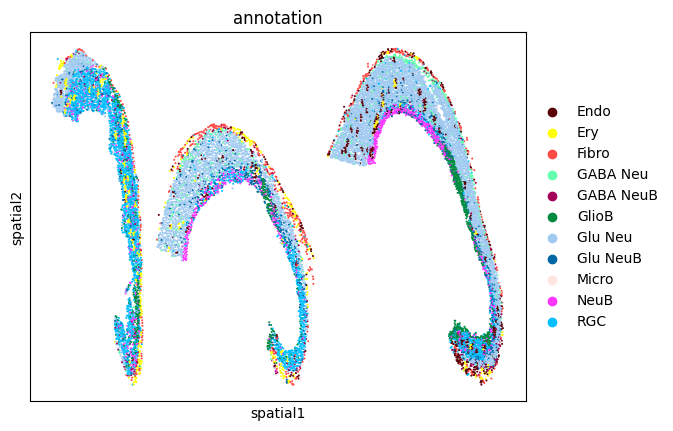

In [5]:
sc.pl.embedding(adata, "spatial", color="annotation")

In [6]:
adata.obs["time"] = adata.obs["Time point"].str.replace("E", "").astype(float)

/local/scratch/tmp/ipykernel_2038962/1262182778.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["time"] = adata.obs["Time point"].str.replace("E", "").astype(float)


## Start preprocessing

In [7]:
# Replace the preprocessed counts with the raw counts.
adata.X = adata.layers["counts"].copy()

In [8]:
sc.pp.calculate_qc_metrics(adata, inplace=True)

In [9]:
# Filter the counts.
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_cells(adata, max_genes=adata.obs["n_genes_by_counts"].quantile(0.999))
sc.pp.filter_genes(adata, min_cells=3)
print("Filtered counts")

Filtered counts


## Proliferation and apoptosis

In [10]:
# from https://github.com/theislab/moscot
mouse_proliferation_genes = list(
    pd.read_csv(
        "/pasteur/zeus/projets/p02/ml4ig_hot/Users/ghuizing/data/dorsal_midbrain/proliferation.txt",
        header=None,
    )[0]
)

In [11]:
# from https://github.com/theislab/moscot
mouse_apoptosis_genes = list(
    pd.read_csv(
        "/pasteur/zeus/projets/p02/ml4ig_hot/Users/ghuizing/data/dorsal_midbrain/apoptosis.txt",
        header=None,
    )[0]
)

In [12]:
sc.tl.score_genes(adata, mouse_proliferation_genes, score_name="proliferation")
sc.tl.score_genes(adata, mouse_apoptosis_genes, score_name="apoptosis")

/pasteur/appa/homes/ghuizing/.cache/pypoetry/virtualenvs/spacetime-5ClciJgR-py3.10/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/pasteur/appa/homes/ghuizing/.cache/pypoetry/virtualenvs/spacetime-5ClciJgR-py3.10/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(
/pasteur/appa/homes/ghuizing/.cache/pypoetry/virtualenvs/spacetime-5ClciJgR-py3.10/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violi

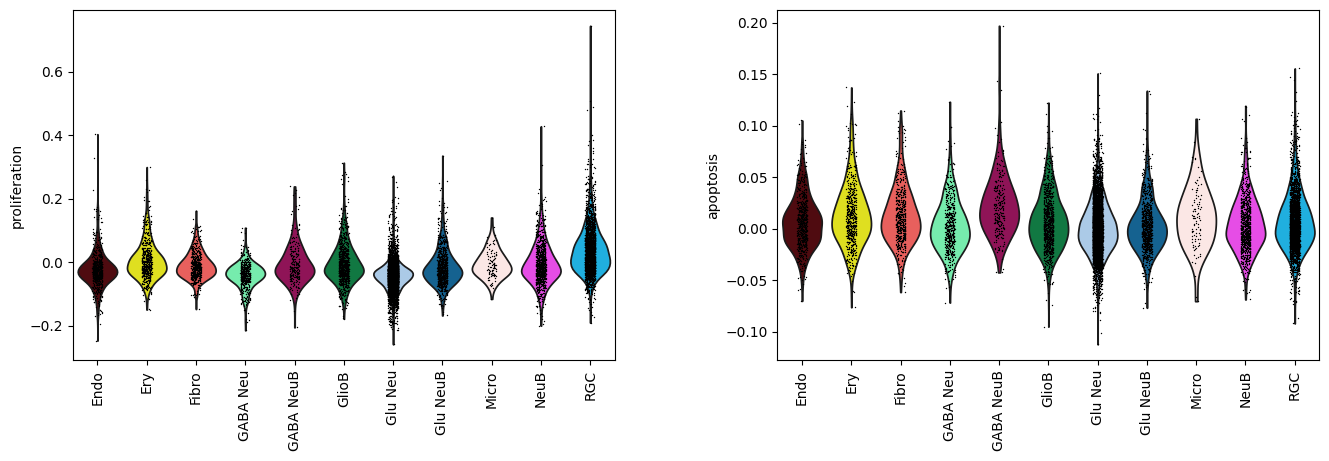

In [13]:
sc.pl.violin(adata, ["proliferation", "apoptosis"], "annotation", rotation=90)

In [14]:
# from https://github.com/theislab/moscot
def _logistic(x, L: float, k: float, center: float = 0):
    return L / (1 + np.exp(-k * (x - center)))


def _gen_logistic(p, sup: float, inf: float, center: float, width: float):
    return inf + _logistic(p, L=sup - inf, k=4.0 / width, center=center)


def beta(p, beta_max=1.7, beta_min=0.3, beta_center=0.25, beta_width=0.5):
    return _gen_logistic(p, beta_max, beta_min, beta_center, beta_width)


def delta(a, delta_max=1.7, delta_min=0.3, delta_center=0.1, delta_width=0.2):
    return _gen_logistic(a, delta_max, delta_min, delta_center, delta_width)


birth = beta(adata.obs["proliferation"].values.astype(float))
death = delta(adata.obs["apoptosis"].values.astype(float))
adata.obs["growth"] = np.exp(birth - death)

/pasteur/appa/homes/ghuizing/.cache/pypoetry/virtualenvs/spacetime-5ClciJgR-py3.10/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/pasteur/appa/homes/ghuizing/.cache/pypoetry/virtualenvs/spacetime-5ClciJgR-py3.10/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


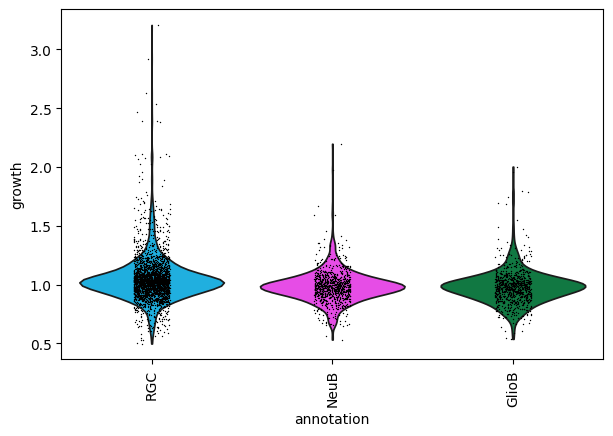

In [15]:
ax = sc.pl.violin(
    adata, "growth", "annotation", show=False, order=["RGC", "NeuB", "GlioB"]
)
plt.xticks(rotation=90);

## Continue preprocessing

In [16]:
# Compute Pearson Residuals.
sc.experimental.pp.highly_variable_genes(
    adata,
    n_top_genes=10_000,
    batch_key="Batch",
    subset=True,
    chunksize=500,
)
sc.experimental.pp.normalize_pearson_residuals(adata)
print("Computed Pearson Residuals")

Computed Pearson Residuals


In [ ]:
# Apply PCA.
sc.tl.pca(adata)
print("Computed PCA")

In [18]:
idx = adata.obs["annotation"] == "RGC"
idx |= adata.obs["annotation"] == "GlioB"
idx |= adata.obs["annotation"] == "NeuB"
adata = adata[idx]

In [20]:
# Integrate the batches.
sc.external.pp.harmony_integrate(adata, key="Batch", max_iter_harmony=20)
print("Integrated batches")

2024-05-29 13:56:15,172 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-05-29 13:56:16,535 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-05-29 13:56:16,561 - harmonypy - INFO - Iteration 1 of 20
2024-05-29 13:56:17,384 - harmonypy - INFO - Iteration 2 of 20
2024-05-29 13:56:18,208 - harmonypy - INFO - Converged after 2 iterations


Integrated batches


/pasteur/appa/homes/ghuizing/.cache/pypoetry/virtualenvs/spacetime-5ClciJgR-py3.10/lib/python3.10/site-packages/scanpy/external/pp/_harmony_integrate.py:84: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata.obsm[adjusted_basis] = harmony_out.Z_corr.T


In [21]:
# Compute the neighbors.
sc.pp.neighbors(adata, use_rep="X_pca_harmony", n_neighbors=200)
print("Computed neighbors")

/pasteur/appa/homes/ghuizing/.cache/pypoetry/virtualenvs/spacetime-5ClciJgR-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Computed neighbors


/pasteur/appa/homes/ghuizing/.cache/pypoetry/virtualenvs/spacetime-5ClciJgR-py3.10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


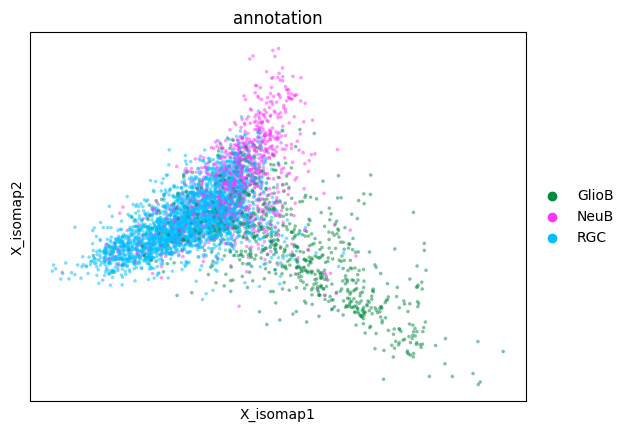

In [22]:
from sklearn.manifold import Isomap

embedding = Isomap(n_components=2)
adata.obsm["X_isomap"] = embedding.fit_transform(adata.obsm["X_pca_harmony"])
sc.pl.embedding(adata, basis="X_isomap", color="annotation", alpha=0.5, show=False)
plt.savefig(
    "/pasteur/zeus/projets/p02/ml4ig_hot/Users/ghuizing/data/dorsal_midbrain/dorsal_midbrain_processed.png"
)
plt.show()

In [23]:
del adata.uns["pearson_residuals_normalization"]

In [24]:
# Save the data.
adata.write_h5ad(
    "/pasteur/zeus/projets/p02/ml4ig_hot/Users/ghuizing/data/dorsal_midbrain/dorsal_midbrain_processed.h5ad"
)
print("Saved data")

Saved data


In [25]:
for b in adata.obs["Batch"].unique():
    print(b)

FP200000600TR_E3
SS200000108BR_A3A4
SS200000108BR_B1B2


In [26]:
adata

AnnData object with n_obs × n_vars = 4581 × 10000
    obs: 'CellID', 'Batch', 'annotation', 'S_score', 'G2M_score', 'phase', 'Time point', 'time', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_genes', 'proliferation', 'apoptosis', 'growth'
    var: 'Gene', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable_nbatches', 'highly_variable_intersection', 'highly_variable'
    uns: 'FP200000600TR_E3', 'SS200000108BR_A3A4', 'SS200000108BR_B1B2', 'SS200000131BL_C3C4', 'SS200000131BL_C5C6', 'angle_dict', 'annotation_colors', 'hvg', 'pca', 'neighbors'
    obsm: 'X_umap', 'spatial', 'X_pca', 'X_pca_harmony', 'X_isomap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distan

/pasteur/appa/homes/ghuizing/.cache/pypoetry/virtualenvs/spacetime-5ClciJgR-py3.10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


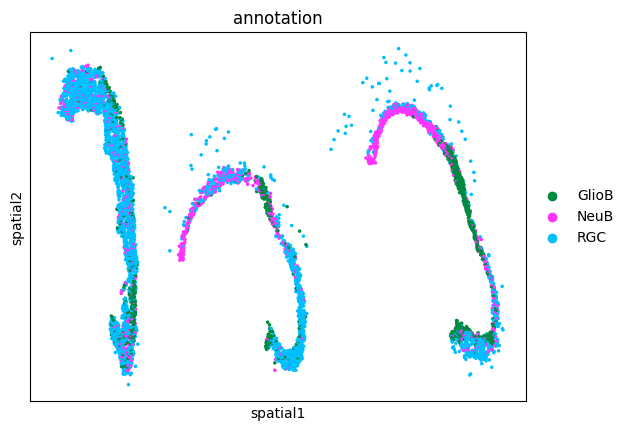

In [27]:
sc.pl.embedding(adata, "spatial", color="annotation")